# Setup (Install/Impor)

In [1]:
# Colab: install deps (safe to re-run)
!pip -q install pandas numpy matplotlib scikit-learn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Inline plots
%matplotlib inline
plt.rcParams["figure.dpi"] = 140

# Get CSV into Colab

In [2]:
from google.colab import files
uploaded = files.upload() # choose smartcity_env_log.csv
CSV_IN = "smartcity_env_log.csv" # file name msut match with what you uploaded

Saving smartcity_env_log.csv to smartcity_env_log.csv


# Data Preprocessing

In [41]:
CSV_OUT = "smartcity_env_log_cleaned.csv"
ANOMALY_OUT = "smartcity_env_anomalies.csv"
PLOTS_PREFIX = "smartcity_env"
RANDOM_STATE = 42
CONTAMINATION = 0.02 # 2% anomalies

def load_and_clean(path: str) -> pd.DataFrame:
  df = pd.read_csv(path)

  # Expect columns: iso_time, epoch_ms, temp_c, hum
  # Build a proper timestamp column t
  if "iso_time" in df.columns and df["iso_time"].notna().any():
    df["t"] = pd.to_datetime(df["iso_time"], errors="coerce")
  elif "epoch_ms" in df.columns:
    # derive relative timeline from epoch_ms if iso_time missing
    t0 = df["epoch_ms"].iloc[0]
    df["t"] = pd.to_datetime(df["epoch_ms"] - t0, unit="ms")
  else:
    raise ValueError("CSV must contain iso_time or epoch_ms")

  # Keep only the columns we need and clean the rows
  df = df[["t", "temp_c", "hum"]].copy()
  df = df.sort_values("t").drop_duplicates(subset=["t"]).dropna(subset=["t"]).reset_index(drop=True)

  # Fix bad/missing numbers in temp_c and hum
  if df["temp_c"].notna().any():
    df["temp_c"] = pd.to_numeric(df["temp_c"], errors="coerce")
    df["temp_c"] = df["temp_c"].fillna(df["temp_c"].mean())
  if df["hum"].notna().any():
    df["hum"] = pd.to_numeric(df["hum"], errors="coerce")
    df["hum"] = df["hum"].fillna(df["hum"].mean())
  return df

# sampling rate
def infer_rolling_window(df: pd.DataFrame, default_secs=60) -> int:
  if len(df) < 3:
    return 5 # If there's almost no data, fall back to a small window of 5 points.
  dt = df["t"].diff().dt.total_seconds().dropna()
  median_dt = float(np.median(dt)) if len(dt) else 2.0
  if not np.isfinite(median_dt) or median_dt <= 0:
    median_dt = 2.0
  return max(3, int(round(default_secs / median_dt)))

# Visualize data

In [42]:
def visualize(df: pd.DataFrame, prefix: str, show=True):
  win = infer_rolling_window(df, 60)
  df["temp_roll"] = df["temp_c"].rolling(win, min_periods=max(1, win//3)).mean()
  df["hum_roll"] = df["hum"].rolling(win, min_periods=max(1, win//3)).mean()

  # Temperature
  plt.figure(figsize=(11,4))
  plt.plot(df["t"], df["temp_c"], label="temp_c")
  plt.plot(df["t"], df["temp_roll"], label=f"rolling mean (~{win} pts)")
  plt.xlabel("time"); plt.ylabel("°C"); plt.title("Temperature over time")
  plt.legend(); plt.tight_layout()
  plt.savefig(f"{prefix}_temp.png")
  if show: plt.show()
  plt.close()

  # Humidity
  plt.figure(figsize=(11,4))
  plt.plot(df["t"], df["hum"], label="hum")
  plt.plot(df["t"], df["hum_roll"], label=f"rolling mean (~{win} pts)")
  plt.xlabel("time"); plt.ylabel("%"); plt.title("Humidity over time")
  plt.legend(); plt.tight_layout()
  plt.savefig(f"{prefix}_hum.png")
  if show: plt.show()
  plt.close()

# Detect Anomaly

In [43]:
def detect_anomalies(df: pd.DataFrame, contamination=0.02, random_state=42, show=True):
  feats = df[["temp_c","hum"]].values
  scaler = StandardScaler()
  X = scaler.fit_transform(feats)

  iso = IsolationForest(
      n_estimators=200,
      contamination=contamination,
      random_state=random_state,
      n_jobs=-1
  )
  pred = iso.fit_predict(X) # 1 normal, -1 anomaly
  score = iso.decision_function(X)

  out = df.copy()
  out["anomaly"] = (pred == -1).astype(int)
  out["anom_score"] = score

  anomalies = out[out["anomaly"] == 1].copy()
  anomalies.to_csv(ANOMALY_OUT, index=False)
  print(f"[Anomaly] Saved {len(anomalies)} rows -> {ANOMALY_OUT}")

  # Quick overlay plot (temp)
  plt.figure(figsize=(11,4))
  plt.plot(out["t"], out["temp_c"], label="temp_c")
  plt.scatter(out.loc[out["anomaly"]==1, "t"], out.loc[out["anomaly"]==1, "temp_c"],
              marker="o", s=40, label="anomaly")
  plt.xlabel("time"); plt.ylabel("°C"); plt.title("Temperature with anomalies")
  plt.legend(); plt.tight_layout()
  plt.savefig(f"{PLOTS_PREFIX}_temp_anom.png")
  if show: plt.show()
  plt.close()

   # Quick overlay plot (humidity)
  plt.figure(figsize=(11,4))
  plt.plot(out["t"], out["temp_c"], label="temp_c")
  plt.scatter(out.loc[out["anomaly"]==1, "t"], out.loc[out["anomaly"]==1, "hum"],
              marker="o", s=40, label="anomaly")
  plt.xlabel("time"); plt.ylabel("%"); plt.title("Humidity with anomalies")
  plt.legend(); plt.tight_layout()
  plt.savefig(f"{PLOTS_PREFIX}_hum_anom.png")
  if show: plt.show()
  plt.close()
  return out

# Extension of dataset based on real data

In [44]:
def add_lag_features(df: pd.DataFrame, cols=("temp_c","hum"), lags=(1,2,3)) -> pd.DataFrame:
  out = df.copy()
  for col in cols:
    for L in lags:
      out[f"{col}_lag{L}"] = out[col].shift(L)
  out = out.dropna().reset_index(drop=True)
  return out

# Simple Forecaster

In [45]:
from math import sqrt
def train_simple_forecaster(df: pd.DataFrame, target_col: str, lags=(1,2,3)):
  data = add_lag_features(df[["t", "temp_c", "hum"]], cols=("temp_c","hum"), lags=lags)
  y = data[target_col].values
  X = data.drop(columns=["t", "temp_c", "hum"]).values

  n = len(data)
  if n < 10:
    raise ValueError("Not enough rows for forecasting after lag creation.")

  split = int(n*0.8)
  X_train, X_test = X[:split], X[split:]
  y_train, y_test = y[:split], y[split:]
  t_test = data["t"].iloc[split:].reset_index(drop=True)

  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  mae = mean_absolute_error(y_test, y_pred)
  rmse = sqrt(mean_squared_error(y_test, y_pred)) # manual RMSE calculation

  df_pred = pd.DataFrame({"t": t_test, f"{target_col}_actual": y_test, f"{target_col}_pred": y_pred})
  return df_pred, mae, rmse

# Run All Steps

[Clean] Saved -> smartcity_env_log_cleaned.csv (rows: 313)


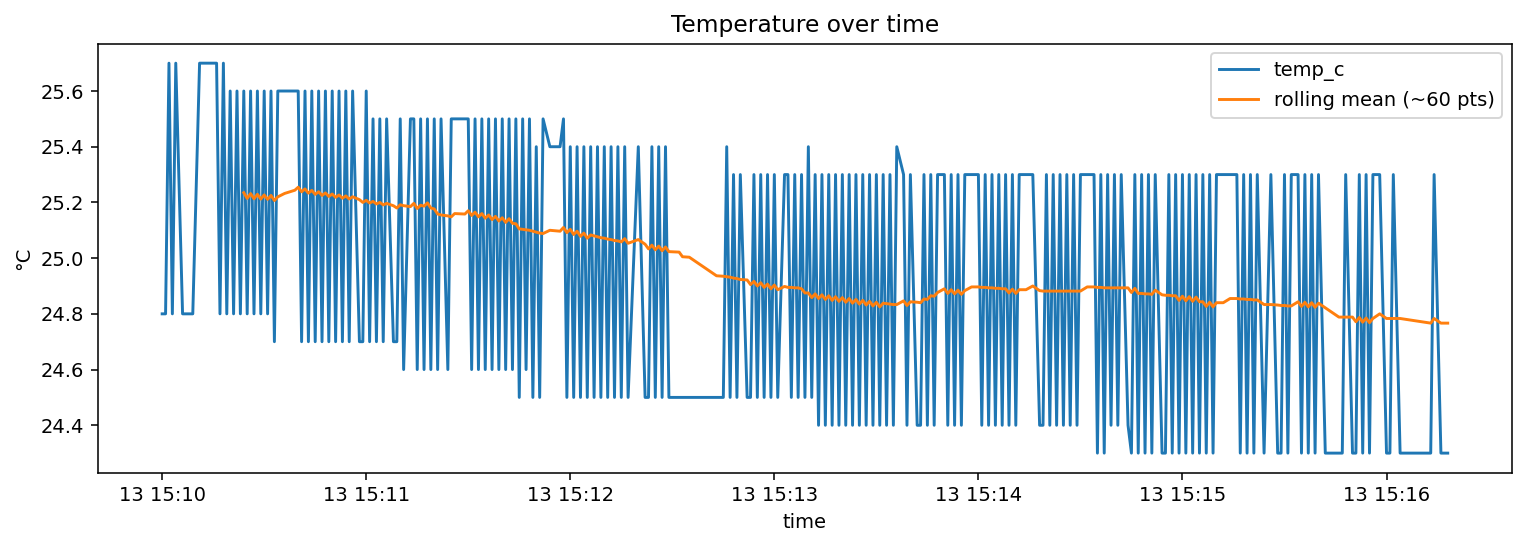

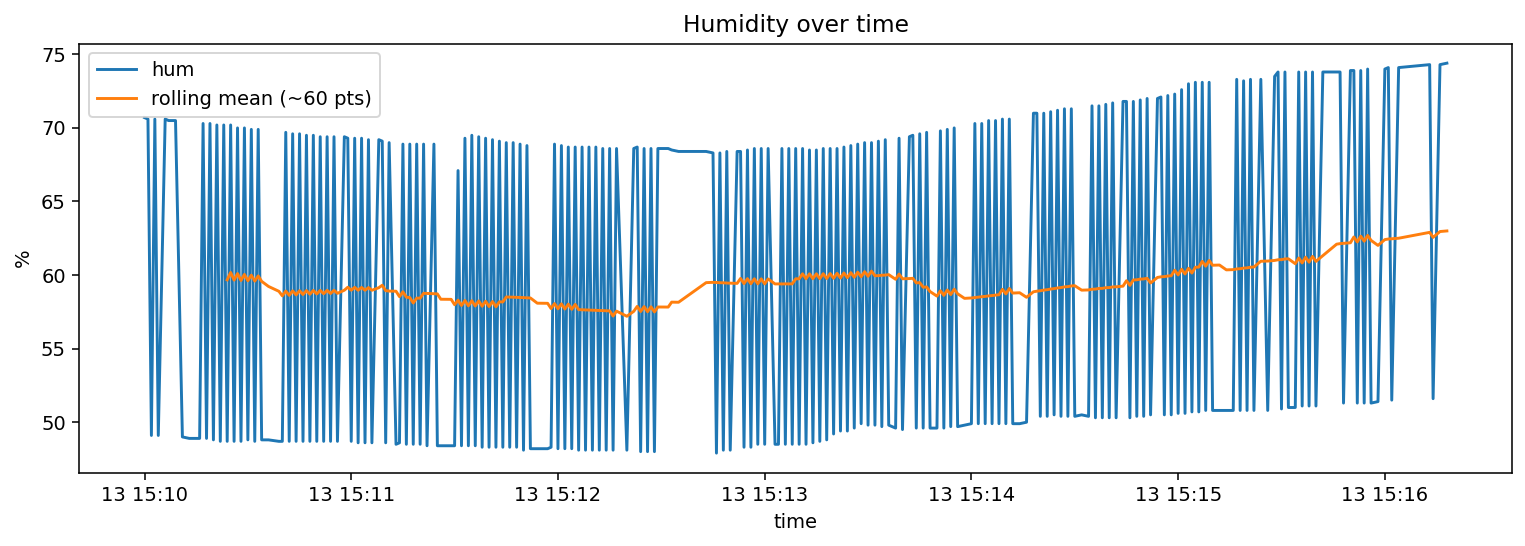

[Viz] Saved: smartcity_env_temp.png, smartcity_env_hum.png
[Anomaly] Saved 7 rows -> smartcity_env_anomalies.csv


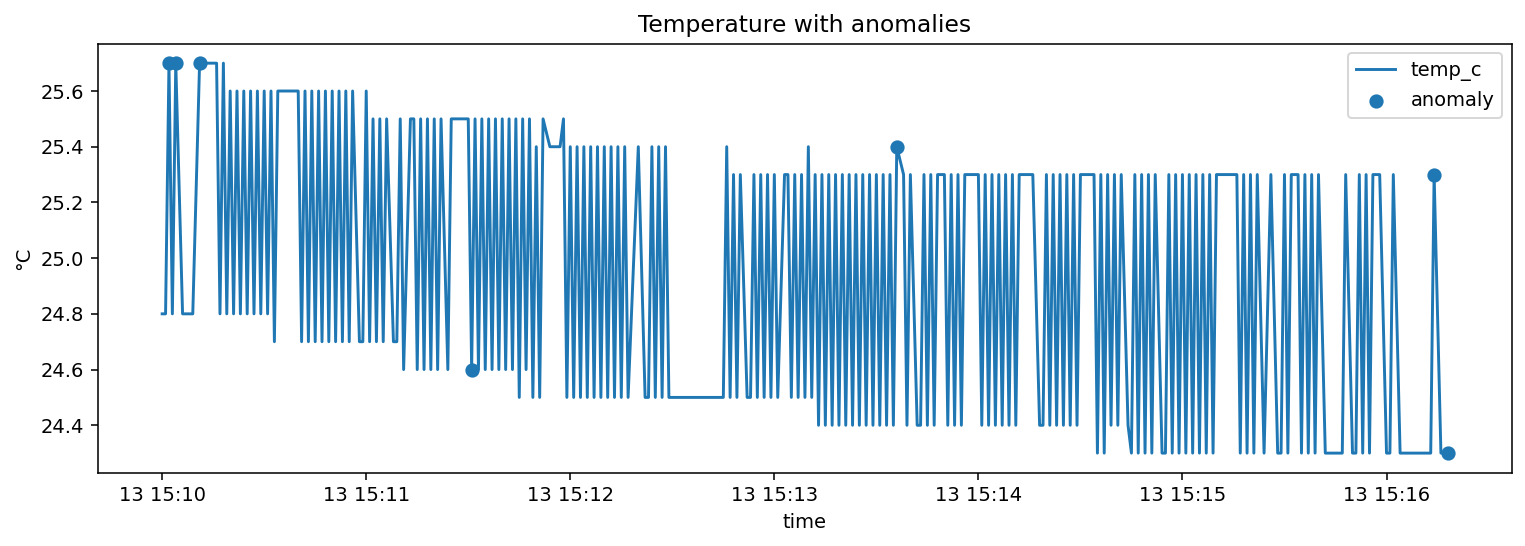

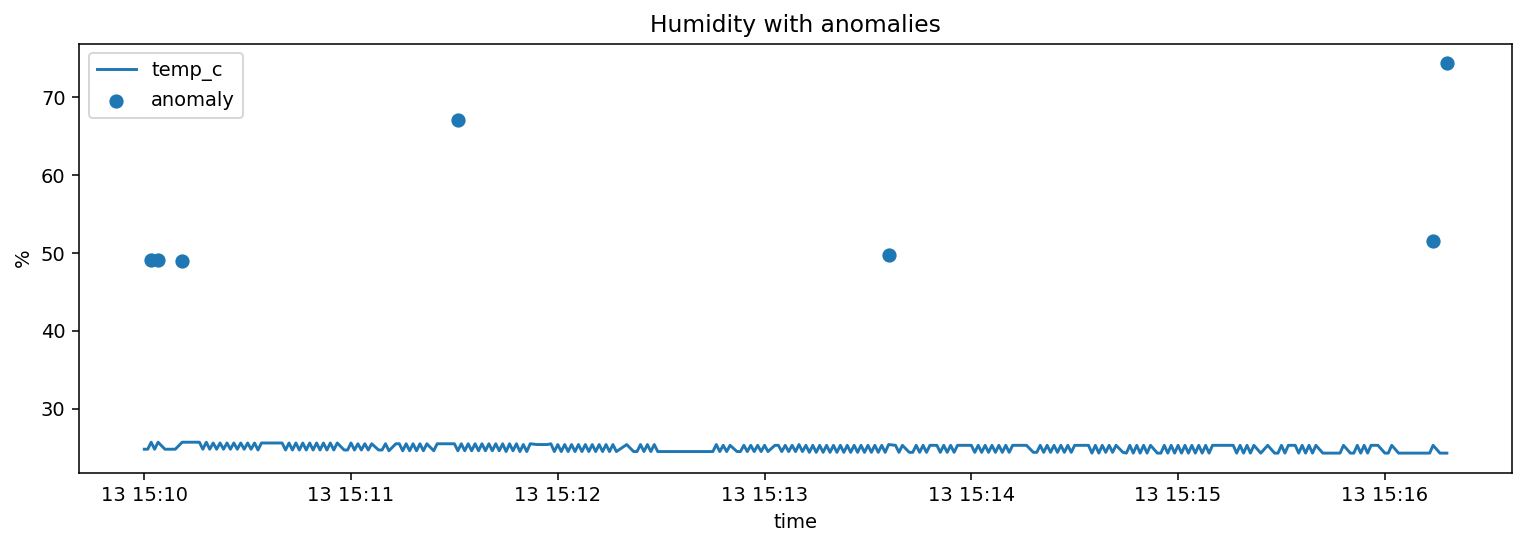

[ML] Temp: MAE=0.337, RMSE=0.468
[ML] Hum : MAE=7.682, RMSE=10.625


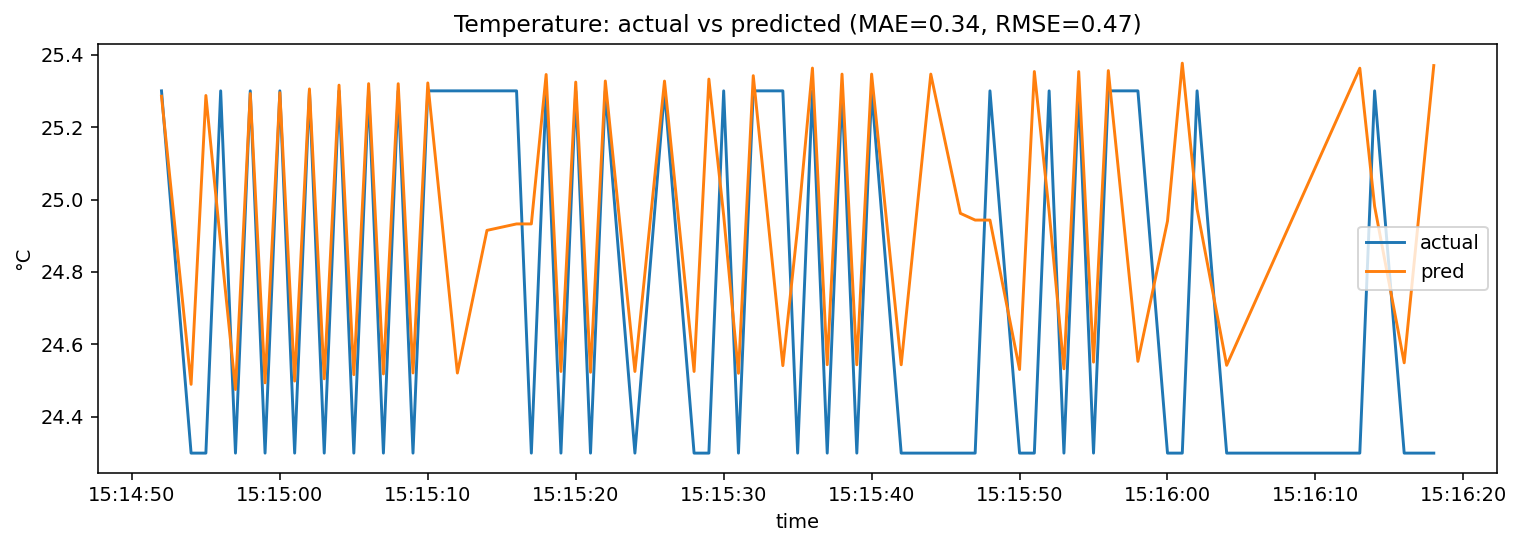

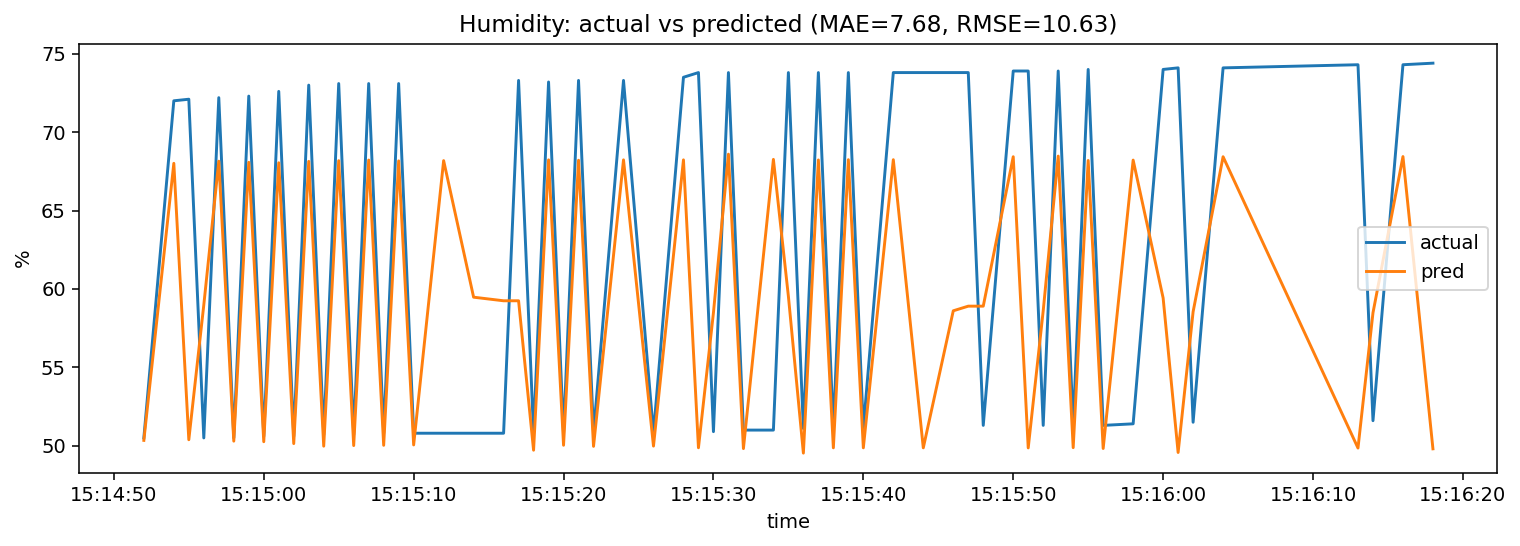

In [46]:
df = load_and_clean(CSV_IN)
df.to_csv(CSV_OUT, index=False)
print(f"[Clean] Saved -> {CSV_OUT} (rows: {len(df)})")

visualize(df, PLOTS_PREFIX, show=True)
print(f"[Viz] Saved: {PLOTS_PREFIX}_temp.png, {PLOTS_PREFIX}_hum.png")

df_an = detect_anomalies(df, contamination=CONTAMINATION, random_state=RANDOM_STATE, show=True)

pred_temp, mae_t, rmse_t = train_simple_forecaster(df_an, "temp_c", lags=(1,2,3))
pred_hum, mae_h, rmse_h = train_simple_forecaster(df_an, "hum", lags=(1,2,3))

pred_temp.to_csv("smart_env_pred_temp.csv", index=False)
pred_hum.to_csv("smartcity_env_pred_hum.csv", index=False)
print(f"[ML] Temp: MAE={mae_t:.3f}, RMSE={rmse_t:.3f}")
print(f"[ML] Hum : MAE={mae_h:.3f}, RMSE={rmse_h:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(11,4))
plt.plot(pred_temp["t"], pred_temp["temp_c_actual"], label="actual")
plt.plot(pred_temp["t"], pred_temp["temp_c_pred"], label="pred")
plt.title(f"Temperature: actual vs predicted (MAE={mae_t:.2f}, RMSE={rmse_t:.2f})")
plt.xlabel("time"); plt.ylabel("°C"); plt.legend(); plt.tight_layout()
plt.savefig(f"{PLOTS_PREFIX}_temp_pred.png"); plt.show(); plt.close()

plt.figure(figsize=(11,4))
plt.plot(pred_hum["t"], pred_hum["hum_actual"], label="actual")
plt.plot(pred_hum["t"], pred_hum["hum_pred"], label="pred")
plt.title(f"Humidity: actual vs predicted (MAE={mae_h:.2f}, RMSE={rmse_h:.2f})")
plt.xlabel("time"); plt.ylabel("%"); plt.legend(); plt.tight_layout()
plt.savefig(f"{PLOTS_PREFIX}_hum_pred.png"); plt.show(); plt.close()